In [33]:
#!pip install umap-learn
#!pip install yellowbrick
#!pip install pyLDAvis
#!pip install gensim

     |████████████████████████████████| 24.2 MB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 75.2 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 9.4 MB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 71.0 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 61.7 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-1.10.0-py3-none-any.whl size=90632 sha256=984483a1780060287d56158311e6e419d9e3610ca83953234a7786f215ad61d9
  Stored in directory: /home/jupyter/.cache/pip/wheels/1f/e5/fc/7412935a7184efc8ad377e948c81b1cc99b6a02eb8dc7c918c
Successfully built smart-open
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


In [34]:
import pandas as pd
from nltk.corpus import stopwords

# visualization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans 

# Probabilistic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import matutils, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import scipy.sparse

import umap.umap_ as umap
from yellowbrick.text import UMAPVisualizer

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/opt/conda/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Helper Functions

In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '", topic_names[ix], "'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [54]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = cv.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [24]:
df = pd.read_csv(f'tweets/tweets_processed/coronavirus_california_tweets_processed', engine = 'python')

In [25]:
df['processed_text'] = df['processed_text'].values.astype(str)

## Vectorizer

In [14]:
stop_words = stopwords.words('english')
stop_words.extend(['coronavirus', 'covid', 'covidー', 'coronavirusoutbreak', 'coronaviruspandemic'])
stop_words = set(stop_words)

In [44]:
num_topics = 4
index_names = [f'component_{x}' for x in range(num_topics)]
random_state = 42
n_gram = (1,1)
min_df = 3
max_df = 0.85

In [45]:
cv = CountVectorizer(analyzer='word',
                     min_df=min_df,
                     max_df=max_df,
                     stop_words=stop_words,
                     lowercase=True,
                     token_pattern='[a-zA-Z0-9]{3,}',
                     max_features=5000,
                     )
data_dtm = cv.fit_transform(df['processed_text'])

## NMF

In [46]:
# tf, dtm = createCustomTFIDFvectorizer(new_df, n_range=(1,2), stop = stop_words)

# don't use TF-IDF for tweets
# use CV because it's a small doc
# suggestion - binary = True ~ can throw in a lot of noise
# cv = CountVectorizer(ngram_range = n_gram, stop_words = stop_words, min_df=min_df, max_df=max_df)
# data_dtm = cv.fit_transform(new_df.full_text)

In [47]:
nmf_model = NMF(n_components = num_topics, random_state = random_state)
doc_topic_nmf = nmf_model.fit_transform(data_dtm)

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                  index=index_names,
                                  columns=cv.get_feature_names())

# doc_topic_nmf_chosen = performCustomNMF(tf, dtm, index_names = index_names)
#len(doc_topic_nmf_chosen)

In [48]:
kmeans = KMeans(n_clusters=num_topics, random_state=random_state).fit(doc_topic_nmf)
cluster_topic_nmf = kmeans.labels_

In [49]:
display_topics(nmf_model, cv.get_feature_names(), 40, topic_names=None)


Topic  0
people, amp, home, get, stay, time, need, help, pandemic, like, one, know, day, order, spread, work, california, going, health, take, please, make, business, many, virus, thing, week, still, crisis, right, way, everyone, safe, life, due, keep, social, say, stop, outbreak

Topic  1
trump, pandemic, president, say, virus, response, american, chinese, donald, china, news, administration, briefing, would, reporter, crisis, calling, drug, call, racist, press, america, state, said, lie, white, could, house, act, force, know, like, medium, government, conference, united, hoax, claim, stop, want

Topic  2
via, pandemic, amid, news, say, stock, million, outbreak, due, live, crisis, business, spread, nyt, senator, worker, doctor, response, briefing, update, dumped, relief, help, world, test, watch, positive, emergency, could, plan, suspend, show, sen, government, video, sign, china, senate, first, company

Topic  3
case, new, state, county, united, death, health, confirmed, update, day

In [55]:
get_nmf_topics(nmf_model, 40)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,people,trump,via,case
1,amp,pandemic,pandemic,new
2,home,president,amid,state
3,get,say,news,county
4,stay,virus,say,united
5,time,response,stock,death
6,need,american,million,health
7,help,chinese,outbreak,confirmed
8,pandemic,donald,due,update
9,like,china,live,day


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single 

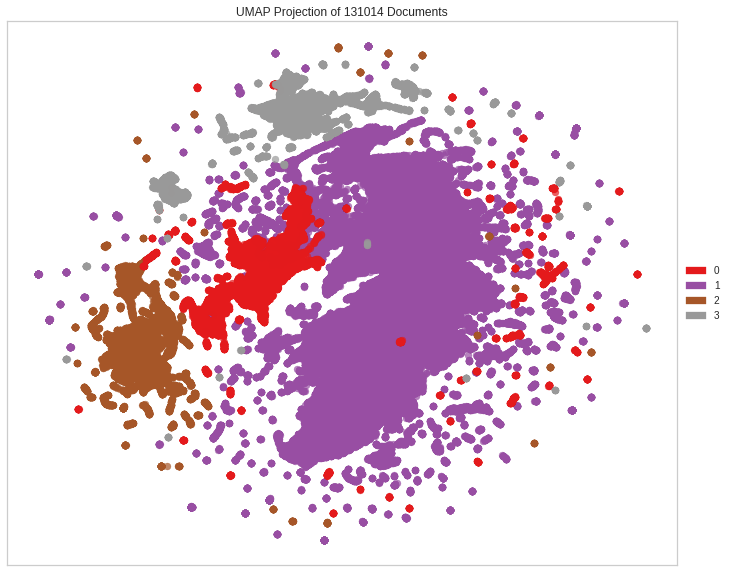

In [56]:
plt.figure(figsize=(15,10))
docs = doc_topic_nmf
labels = cluster_topic_nmf

umap = UMAPVisualizer(metric ='euclidean', colormap = 'Set1', random_state=42)
umap.fit(docs, labels)
umap.show()

## LDA

In [57]:
# vectorizer = CountVectorizer(analyzer='word',
#                              min_df=min_df,
#                              max_df=max_df,
#                              stop_words=stop_words,
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              max_features=5000,
#                              )

# data_vectorized = vectorizer.fit_transform(data_df['script'])
lda_model = LatentDirichletAllocation(n_components=num_topics,  # Number of topics
                                      learning_method='online',
                                      random_state=random_state,
                                      n_jobs=-1  # Use all available CPUs
                                      )
lda_output = lda_model.fit_transform(data_dtm)

display_topics(lda_model, cv.get_feature_names(), 40)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_dtm, cv, mds='tsne')


Topic  0
people, get, time, home, like, stay, virus, take, amp, going, one, day, quarantine, need, please, life, thing, good, would, make, let, school, work, everyone, stop, got, back, still, think, even, community, world, dont, chinese, really, see, year, safe, month, come

Topic  1
trump, news, via, county, due, amid, pandemic, response, positive, case, say, new, update, china, president, tested, live, outbreak, health, public, american, company, information, latest, doctor, testing, use, medium, official, government, article, world, give, big, post, shit, change, already, san, first

Topic  2
help, business, know, via, amp, health, need, right, social, worker, pandemic, family, care, emergency, house, open, distancing, video, sick, outbreak, medical, relief, support, hand, risk, kid, friend, resource, long, face, fight, free, best, mask, people, symptom, tip, crisis, supply, virus

Topic  3
state, new, california, test, united, via, week, could, case, order, say, death, hospital, k

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  30.388497
3        1.782994 -295.079681       2        1  24.910279
1      220.811432 -343.832123       3        1  22.933737
2       50.533993  -76.050934       4        1  21.767488, topic_info=          Term         Freq         Total Category  logprob  loglift
4591     trump  9157.000000   9157.000000  Default  30.0000  30.0000
4181     state  6018.000000   6018.000000  Default  29.0000  29.0000
1896       get  6244.000000   6244.000000  Default  28.0000  28.0000
2923      news  4980.000000   4980.000000  Default  27.0000  27.0000
2112      home  5905.000000   5905.000000  Default  26.0000  26.0000
...        ...          ...           ...      ...      ...      ...
2904      need  2557.191381   5304.637005   Topic4  -4.6698   0.7951
4746       via  3501.296919  11822.646606   Topic4  -4.3555   0.3079
3683  resource  1292.371467   1479.859191   Topic4  -5.3522   1.3893
3091  pandemic  2436.628080   8985.503217   Topic4  -4.7181   0.2198
3055  outbreak  1439.251204   4565.270734   Topic4  -5.2446   0.3704

[209 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
136       3  0.999115   already
138       2  0.999420      also
149       2  0.406792  american
149       3  0.593081  american
150       3  0.999827      amid
...     ...       ...       ...
4929      4  0.284974      work
4931      4  0.999840    worker
4934      1  0.999420   working
4950      1  0.999691     would
4983      2  0.999671      york

[237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])


Topic  0
people, state, amp, virus, get, united, time, take, going, please, like, life, would, one, school, world, government, community, dont, chinese, many, way, year, month, store, think, job, back, said, even, stop, make, let, work, together, share, last, show, pandemic, around

Topic  1
trump, via, due, amid, pandemic, news, american, like, crisis, see, close, got, response, president, information, latest, look, doctor, getting, hope, give, use, los, article, angeles, read, big, post, end, shit, change, medium, feel, thank, time, world, call, stop, help, pay

Topic  2
health, case, county, update, test, business, positive, new, public, worker, via, family, outbreak, tested, care, official, live, plan, first, open, local, news, testing, sick, employee, relief, support, hour, friend, medical, long, amp, face, response, emergency, closed, help, mask, city, house

Topic  3
say, via, week, could, new, china, keep, million, hospital, pandemic, stock, report, death, service, italy, day,

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  22.921160
4       51.163364 -159.968018       2        1  20.933590
3      -73.144554   21.523815       3        1  20.347392
1      -66.410133 -110.606438       4        1  18.752238
2       54.417324   12.443444       5        1  17.045619, topic_info=          Term         Freq         Total Category  logprob  loglift
4591     trump  9091.000000   9091.000000  Default  30.0000  30.0000
2112      home  5987.000000   5987.000000  Default  29.0000  29.0000
4181     state  5844.000000   5844.000000  Default  28.0000  28.0000
3831       say  5267.000000   5267.000000  Default  27.0000  27.0000
2048    health  4660.000000   4660.000000  Default  26.0000  26.0000
...        ...          ...           ...      ...      ...      ...
2145      hour  1390.767104   1881.010391   Topic5  -5.0343   1.4673
3055  outbreak  2013.525542   4562.116630   Topic5  -4.6643   0.9514
4746       via  2464.625444  11803.610547   Topic5  -4.4621   0.2029
4429   testing  1527.057003   2761.713231   Topic5  -4.9408   1.1768
2923      news  1527.213734   4962.445470   Topic5  -4.9407   0.5908

[250 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
149       4  0.999599  american
150       4  0.999774      amid
155       1  0.633663       amp
155       2  0.076302       amp
155       3  0.042910       amp
...     ...       ...       ...
4938      4  0.325930     world
4950      1  0.999593     would
4974      1  0.848640      year
4974      4  0.150800      year
4983      3  0.998946      york

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])